# Emoji Hunt Challenge - Classical Methods
This notebook encapasulates our attempt at the emoji hunt challenge using classical computer vision methods, ie: not deep learning.

## Runtime environment
This notebook is intended to be run on Google collab which provides all of the packages this projects needs with exception to the emoji hunt challenge package. Running the cell below will install that package.

In [ ]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt

Current project version:
emojihunt==1.1.1


## Implementation of method

In [ ]:
import json
import matplotlib.pyplot as plt
import cv2
from emojihunt import *

### Load the test image and the target emoji
This step gets the test image and the emoji target from the challenge package then converts them both to the LAB colour space.

169001437/169001437 [==============================] - 4s 0us/step


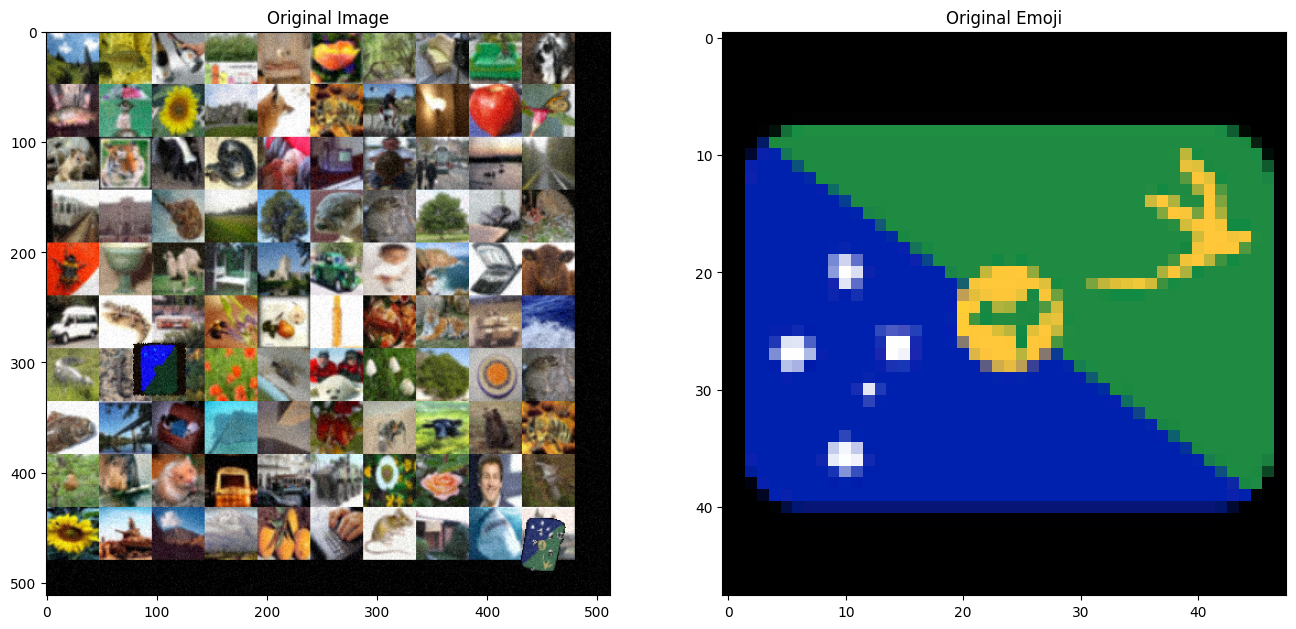

In [ ]:
# Get image and emoji
emoji_hunt_object = EmojiHunt() 
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

# Convert to RGB
rgb_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
rgb_emoji = cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB)

# Convert to LAB
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
emoji_target = cv2.cvtColor(emoji_target, cv2.COLOR_BGR2LAB)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Original Image')

ax[1].imshow(cv2.cvtColor(emoji_target, cv2.COLOR_LAB2RGB))
ax[1].set_title('Original Emoji')
plt.show()

### Segment both images using SLIC
First we remove the background from and the emoji image. This assumes that the background is always the same colour, which we believe is a safe assumption after inspecting the mechanics behind generating images and emojis. Next we run SLIC on the parts of the emoji that we determined where not the background and the entire image.

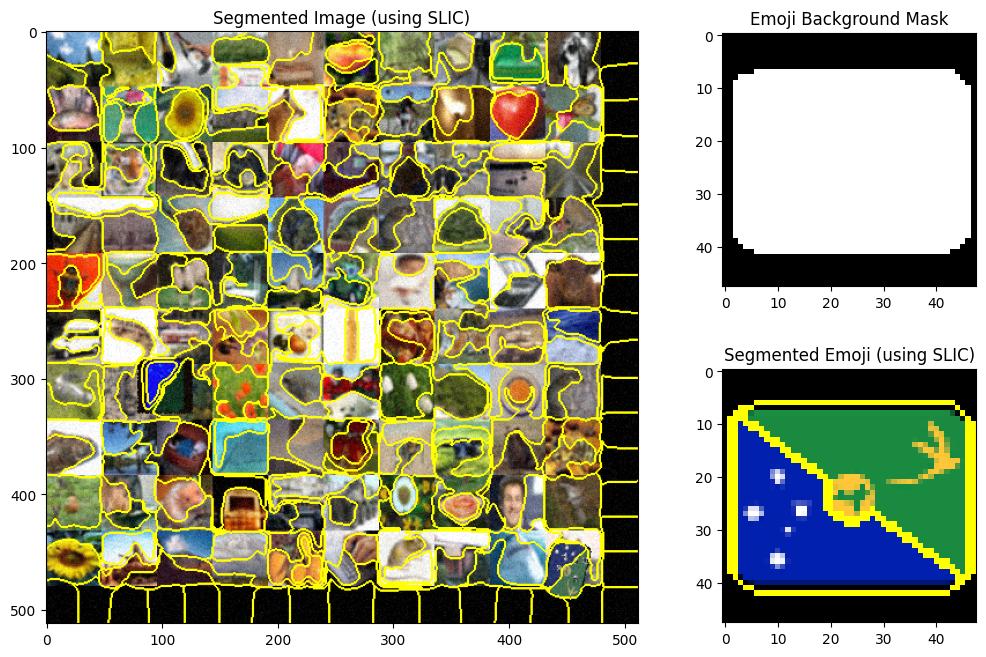

In [ ]:
from skimage.segmentation import slic, mark_boundaries

emoji_background_mask = np.mean(rgb_emoji, axis=-1) != 0

# Segment both images
segmented_image = slic(rgb_image, n_segments=300, compactness=10, sigma=3, enforce_connectivity=True)
segmented_emoji = slic(rgb_emoji, n_segments=2, mask=emoji_background_mask, enforce_connectivity=True)

# Plot the results
fig = plt.figure(figsize=(12,8))

gs = fig.add_gridspec(2, 2, width_ratios=[7, 3])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

ax1.imshow(mark_boundaries(rgb_image, segmented_image))
ax1.set_title('Segmented Image (using SLIC)')

ax2.imshow(emoji_background_mask, cmap=plt.cm.gray)
ax2.set_title('Emoji Background Mask')

ax3.imshow(mark_boundaries(rgb_emoji, segmented_emoji))
ax3.set_title('Segmented Emoji (using SLIC)')

plt.show()

### Compute the average colour of each super pixel in the segmented images

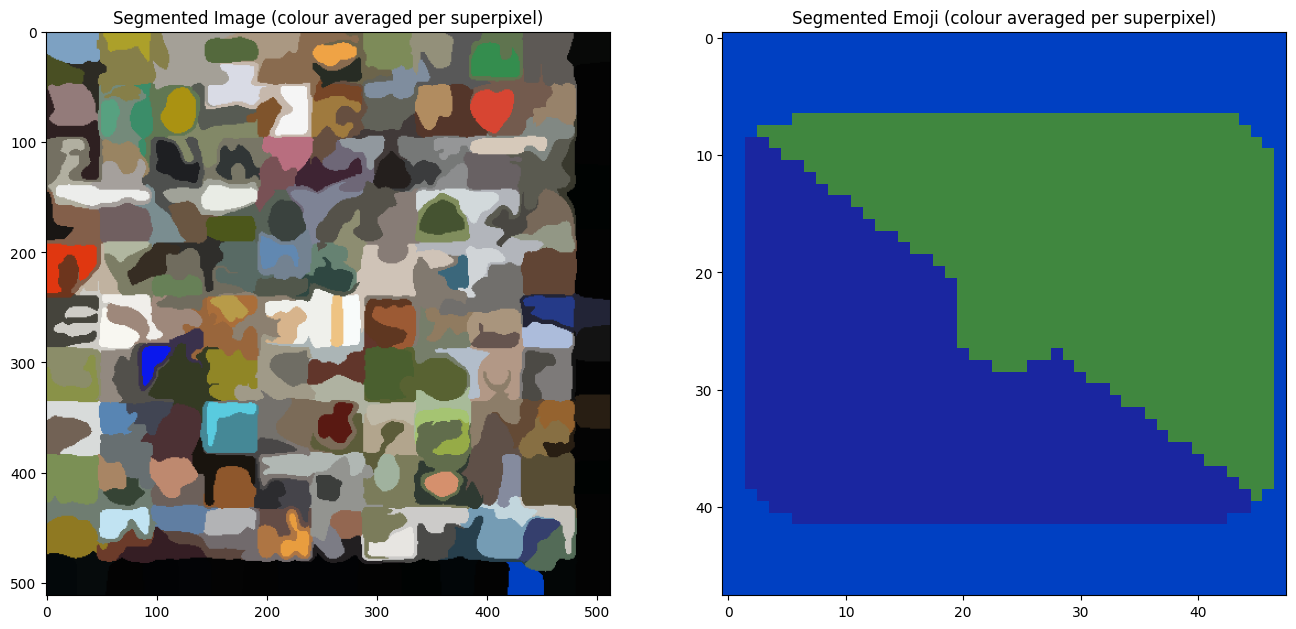

In [ ]:
def average_super_pixels(original_image, segmented_image):
    # Given the original image (in the LAB color space) and its segmented
    # counterpart return an image where each pixel within a super pixel has
    # been set to the average colour of that superpixel as well as a list of
    # the computed colour means for each segment

    n_segments = len(np.unique(segmented_image)) - 1
    segment_means = np.zeros((n_segments, 3))
    segment_pixel_counts = np.zeros(n_segments, dtype=int)
    averaged_image = np.zeros_like(original_image)

    for i in range(n_segments):
        segment_means[i] = np.mean(original_image[segmented_image == i + 1], axis=0)
        averaged_image[segmented_image == i + 1] = segment_means[i]
        segment_pixel_counts[i] = np.sum(segmented_image == i + 1)

    return averaged_image, segment_means, segment_pixel_counts

color_averaged_image, image_segment_mean_colors, image_segment_pixel_counts = average_super_pixels(test_image, segmented_image)
color_averaged_emoji, emoji_segment_mean_colors, emoji_segment_pixel_counts = average_super_pixels(emoji_target, segmented_emoji)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(cv2.cvtColor(color_averaged_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Segmented Image (colour averaged per superpixel)')

ax[1].imshow(cv2.cvtColor(color_averaged_emoji, cv2.COLOR_LAB2RGB))
ax[1].set_title('Segmented Emoji (colour averaged per superpixel)')
plt.show()

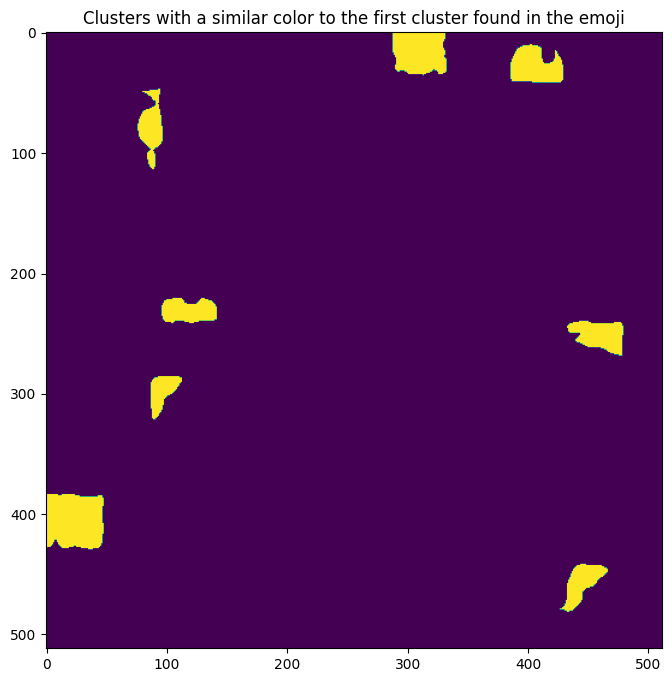

In [ ]:
# Find similar clusters
similarity_scores = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1], color_averaged_image.shape[1]))
for y in range(color_averaged_image.shape[0]):
    for x in range(color_averaged_image.shape[1]):
        for c in range(emoji_segment_mean_colors.shape[0]):
            similarity_scores[y, x, c] = np.sqrt((emoji_segment_mean_colors[c, 0] - color_averaged_image[y, x, 0])**2 + (emoji_segment_mean_colors[c, 1] - color_averaged_image[y, x, 1])**2 + (emoji_segment_mean_colors[c, 2] - color_averaged_image[y, x, 2])**2)

# Map similar clusters to an image to find the emojis!
matching_segments = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1], emoji_segment_mean_colors.shape[0]), dtype=int)
for c in range(emoji_segment_mean_colors.shape[0]):
    matching_segments[similarity_scores[:,:,c] < np.min(similarity_scores[:,:,c]) + 20] = 1

# Plot the mask found showing where emojis are for the first group of similar clusters
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(matching_segments[:,:,0])
ax.set_title('Clusters with a similar color to the first cluster found in the emoji')
plt.show()

### Using a sliding window approach, look for similar clusters

In [ ]:
window_size = 32
found_emojis = np.zeros((matching_segments.shape[0], matching_segments.shape[1]), dtype=int)
for row in range(0, matching_segments.shape[0]):
    for col in range(0, matching_segments.shape[1]):
        window = matching_segments[row:row+window_size, col:col+window_size, :]
        
        counts = np.zeros(matching_segments.shape[2])
        for c in range(counts.shape[0]):
            counts[c] = np.sum(window[:, :, c])

        if np.sum(counts) > 0.8 * window_size**2:
            found_emojis[row:row+window_size, col:col+window_size] = np.sum(window, axis=-1)

found_emojis[found_emojis > 1] = 1

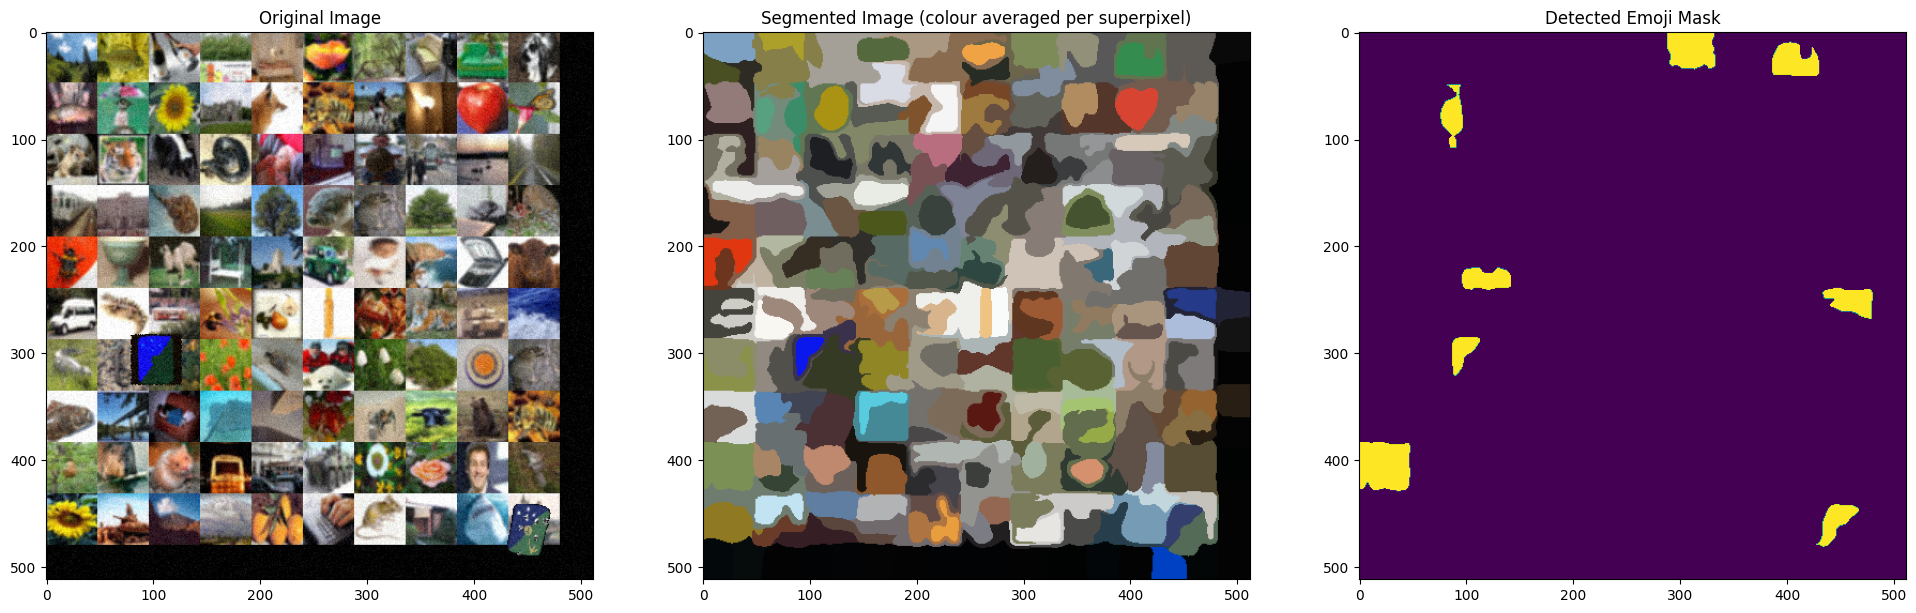

In [ ]:
# Bringing it all together into one graph
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
ax[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Original Image')

ax[1].imshow(cv2.cvtColor(color_averaged_image, cv2.COLOR_LAB2RGB))
ax[1].set_title('Segmented Image (colour averaged per superpixel)')

ax[2].imshow(found_emojis)
ax[2].set_title('Detected Emoji Mask')
plt.show()

### Compute the centroids
Given the mask, we wish to compute the centroids. This will use the same function as the ML method.

In [ ]:
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans

def centroids_from_mask(pred_mask):
    # Create regions from the segmentation mask
    ret_coords = []
    segments = [region for region in regionprops(label(pred_mask)) if region.area > 45]
    
    # Good stats
    mean_area = np.mean([region.area for region in segments])
    median_area = np.median([region.area for region in segments])
    mean_perimeter = np.mean([region.perimeter for region in segments])
    median_perimeter = np.median([region.perimeter for region in segments])
    std_area = np.std([region.area for region in segments])
    std_perimeter = np.std([region.perimeter for region in segments])
    
    # Find possible cluster elements that are otherwise too small
    possible_clusters = [region for region in segments if region.area < median_area]
    for c in possible_clusters:
        segments.remove(c)

    # Find possible touching regions that should be seperate (usually they're just too big)
    possible_touching = [region for region in segments if region.area > mean_area + std_area*1.5 or region.perimeter > median_perimeter + (std_perimeter*1.5)]
    for c in possible_touching:
        segments.remove(c)

    confirmed_centroids = [props.centroid for props in segments]

    # Merge nearby clusters
    while len(possible_clusters) > 0:
        region = possible_clusters[0]
        nearby_clusters = [region2 for region2 in possible_clusters if np.linalg.norm(np.array(region.centroid) - np.array(region2.centroid)) < 20]
        if len(nearby_clusters) > 0:
            # Merge nearby clusters
            new_centroid = np.mean([region.centroid for region in nearby_clusters], axis=0)
            confirmed_centroids.append(new_centroid)
            for cluster in nearby_clusters:
                possible_clusters.remove(cluster)
        else:
            # Nothing nearby, so it's a new cluster
            confirmed_centroids.append(region.centroid)
            possible_clusters.remove(region)

    # For each large cluster, seperate it into two clusters if it is not approximately a square (which would indicate its a large emoji)
    while len(possible_touching) > 0:
        region = possible_touching[0]

        edge_length = region.perimeter / 4
        if edge_length * 0.9 < np.sqrt(region.area_filled) < edge_length * 1.1:
            confirmed_centroids.append(region.centroid)
        else:
            cluster_centroids = KMeans(n_clusters=2, n_init='auto').fit(region.coords).cluster_centers_
            for centroid in cluster_centroids:
                confirmed_centroids.append(centroid)

        possible_touching.remove(region)


    ret_coords = [(int(cx), int(cy)) for cx, cy in confirmed_centroids] 
    return ret_coords

In [ ]:
print(centroids_from_mask(found_emojis))

[(16, 310), (28, 406), (251, 459), (78, 87), (231, 118), (298, 96), (457, 444), (405, 23)]


## Bring everything together into one function to test

In [ ]:
def find_emojis(test_image, emoji_target):
    # Convert to RGB
    rgb_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    rgb_emoji = cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB)

    # Convert to LAB
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
    emoji_target = cv2.cvtColor(emoji_target, cv2.COLOR_BGR2LAB)

    # Find emoji background mask
    emoji_background_mask = np.mean(rgb_emoji, axis=-1) != 0

    # Segment both images
    segmented_image = slic(rgb_image, n_segments=300, compactness=10, sigma=3, enforce_connectivity=True)
    segmented_emoji = slic(rgb_emoji, n_segments=2, mask=emoji_background_mask, enforce_connectivity=True)

    # Compute the average colour of each superpixl
    color_averaged_image, image_segment_mean_colors, image_segment_pixel_counts = average_super_pixels(test_image, segmented_image)
    color_averaged_emoji, emoji_segment_mean_colors, emoji_segment_pixel_counts = average_super_pixels(emoji_target, segmented_emoji)

    # Find similar clusters
    similarity_scores = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1], color_averaged_image.shape[1]))
    for y in range(color_averaged_image.shape[0]):
        for x in range(color_averaged_image.shape[1]):
            for c in range(emoji_segment_mean_colors.shape[0]):
                similarity_scores[y, x, c] = np.sqrt((emoji_segment_mean_colors[c, 0] - color_averaged_image[y, x, 0])**2 + (emoji_segment_mean_colors[c, 1] - color_averaged_image[y, x, 1])**2 + (emoji_segment_mean_colors[c, 2] - color_averaged_image[y, x, 2])**2)

    # Map similar clusters to an image to find the emojis!
    matching_segments = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1], emoji_segment_mean_colors.shape[0]), dtype=int)
    for c in range(emoji_segment_mean_colors.shape[0]):
        matching_segments[similarity_scores[:,:,c] < np.min(similarity_scores[:,:,c]) + 10] = 1

    # Using a sliding window, find similar clusters to the emojis clusters
    window_size = 32
    found_emojis_mask = np.zeros((matching_segments.shape[0], matching_segments.shape[1]), dtype=int)
    for row in range(0, matching_segments.shape[0], 4):
        for col in range(0, matching_segments.shape[1], 4):
            window = matching_segments[row:row+window_size, col:col+window_size, :]
            
            counts = np.zeros(matching_segments.shape[2])
            for c in range(counts.shape[0]):
                counts[c] = np.sum(window[:, :, c])

            if np.sum(counts) > 0.8 * window_size**2:
                found_emojis_mask[row:row+window_size, col:col+window_size] = np.sum(window, axis=-1)
    found_emojis_mask[found_emojis_mask > 1] = 1

    # Finally, compute the centroids and return them
    return centroids_from_mask(found_emojis_mask)

emoji_hunt_object = EmojiHunt() 
config = emoji_hunt_object.get_config()
emoji_hunt_object.update_config(config)
emoji_hunt_object.offical_test(find_emojis, emoji_hunt_object.get_config())

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
     Grayscale
     ChangeColorTemperature
     SigmoidContrast
     CLAHE
     Emboss
     DirectedEdgeDetect
     Fliplr
     PiecewiseAffine
     PerspectiveTransform
     WithPolarWarping
     Rot90
     ElasticTransformation
     Jigsaw
Scores (lower is better)....
    Run 0 -> 48.973555984398104
    Run 1 -> 378.9119990305452
    Run 2 -> 298.00561038326776
    Run 3 -> 57.076640214131544
    Run 4 -> 101.44992995229924
    Run 5 -> 512.0
    Run 6 -> 409.9
    Run 7 -> 213.5935231539548
    Run 8 -> 192.62556079932364
    Run 9 -> 403.66544473877343
    Run 10 -> 330.28079729082754
    Run 11 -> 308.1951532750364
    Run 12 -> 157.12417264660596
    Run 13 -> 409.9828427124747
    Run 14 -> 366.7480097110714
    Run 15 -> 121